# This script is for multilayer/stacked RNN model for forecasting the trends

In [1]:
# importing libraries, warnings and models
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
print('cuda' if torch.cuda.is_available() else cpu) 

cuda


In [2]:
# loading the data and data preprocessing
file_name='time_series_covid19_confirmed_global.csv'
country='US'
data = pd.read_csv(file_name)
data = data.drop(['Province/State','Lat','Long'], axis = 1)
data = data[data['Country/Region'] == country]
data = pd.DataFrame(data = data.T)
data = data.rename(columns={'index':'DATE',225:'cases'})
y_org=data['cases'][1:].values.astype(float)
x=np.arange(0,len(y_org))
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(y_org.reshape(-1, 1))

In [3]:
# Define a test size, create train and test sets
test_size = 14
train_set = y[:-test_size]
test_set = y[-test_size:]
train_set_x = x[:-test_size]
test_set_x = x[-test_size:]

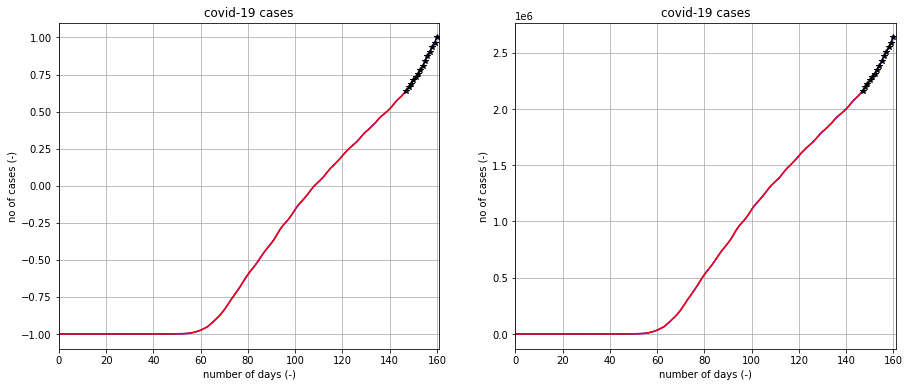

In [4]:
# data visualization to check the outliers
fig = plt.figure(figsize=(15,6))
plt.subplot(122)
plt.subplot(1,2,1)
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
plt.plot(x,y,'-b')
plt.plot(train_set_x, train_set, 'r')
plt.plot(test_set_x,test_set, '*k')
#################################################################
plt.subplot(1,2,2)
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
y_total=scaler.inverse_transform(y)
plt.plot(x,y_total,'-b')
train_set_y=scaler.inverse_transform(train_set)                         
plt.plot(train_set_x, train_set_y, 'r')
test_set_y=scaler.inverse_transform(test_set)
plt.plot(test_set_x,test_set_y, '*k')
warnings.filterwarnings(action='once')

In [5]:
# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [6]:
# defining the Neural Network parameters
hidden_size=300 #[20, 50, 100, 150, 200, 250, 300]
num_layers=3 #[1 2 3 4 5]
lr=0.00001 #[0.1, 0.01, 0.001, 0.0001, 0.00001]
# do not have to change these values
window_size = 30
eps=20
input_size=1 
output_size=1

# Multilayer RNN 

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Add an RNN layer:
        self.RNN = nn.RNN(self.input_size,self.hidden_size,self.num_layers)
        #Add a fully-connected layer:
        self.linear = nn.Linear(self.hidden_size, output_size)
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(self.num_layers,1,self.hidden_size).cuda(),
                       torch.zeros(self.num_layers,1,self.hidden_size).cuda())
    def forward(self, seq):
        rnn_out, self.hidden = self.RNN(seq.view(len(seq), 1,-1))
        pred = self.linear(rnn_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [8]:
# implementing Adam optimizer
torch.manual_seed(101)
model = RNN(input_size, hidden_size, output_size, num_layers).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
model

RNN(
  (RNN): RNN(1, 300, num_layers=3)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [9]:
#function to claculate the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   300
 90000
   300
   300
 90000
 90000
   300
   300
 90000
 90000
   300
   300
   300
     1
______
452401


## Training and simultaneous validation with known data and simultaneous plotting to see the comparision

Epoch:                    1 Loss: 0.44650042
Loss on test predictions: 0.8182157874107361


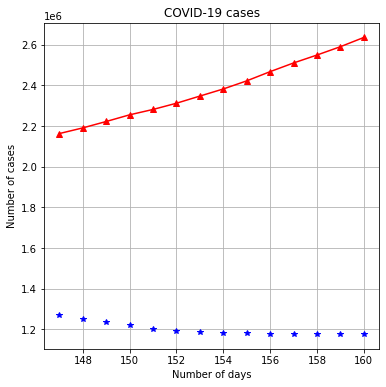

Epoch:                    2 Loss: 0.17353681
Loss on test predictions: 0.5003533363342285


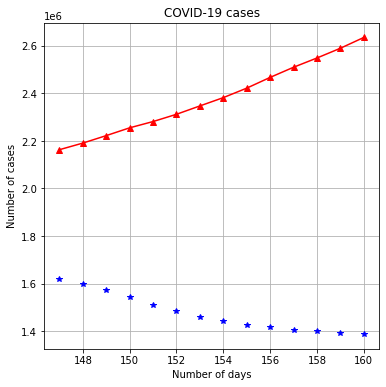

Epoch:                    3 Loss: 0.00207300
Loss on test predictions: 0.03968849778175354


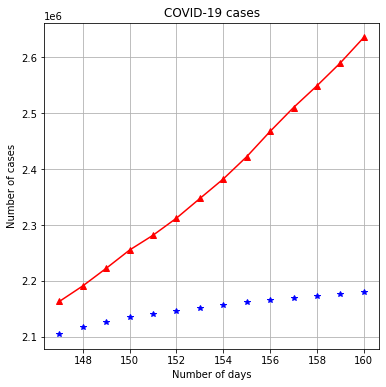

Epoch:                    4 Loss: 0.00039723
Loss on test predictions: 0.01885116472840309


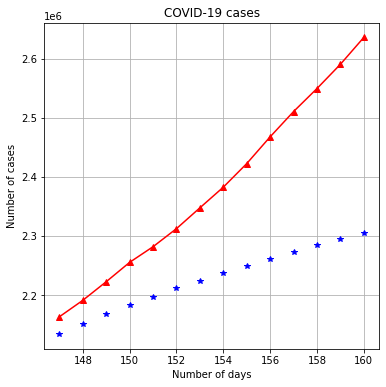

Epoch:                    5 Loss: 0.00035096
Loss on test predictions: 0.019344745203852654


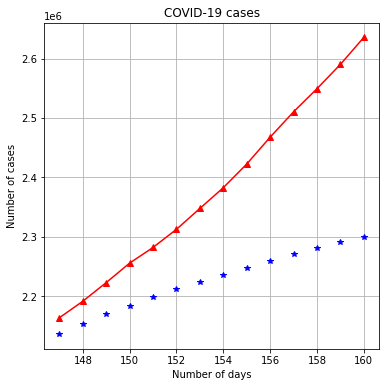

Epoch:                    6 Loss: 0.00025442
Loss on test predictions: 0.01752052828669548


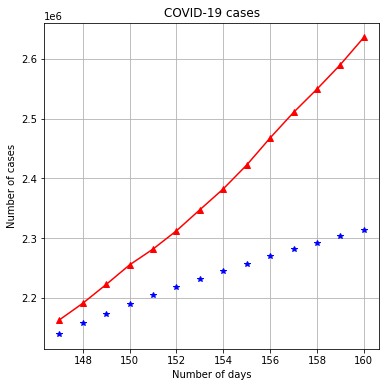

Epoch:                    7 Loss: 0.00019574
Loss on test predictions: 0.016593705862760544


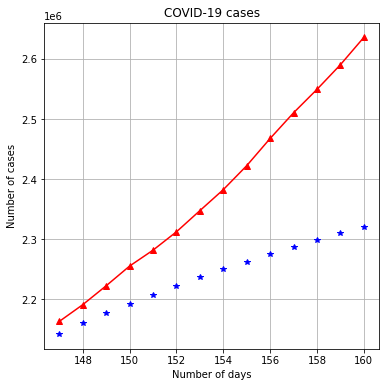

Epoch:                    8 Loss: 0.00015266
Loss on test predictions: 0.015800749883055687


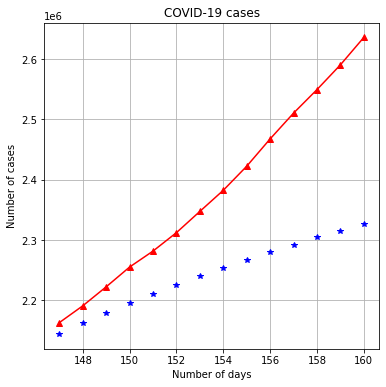

Epoch:                    9 Loss: 0.00012423
Loss on test predictions: 0.015275015495717525


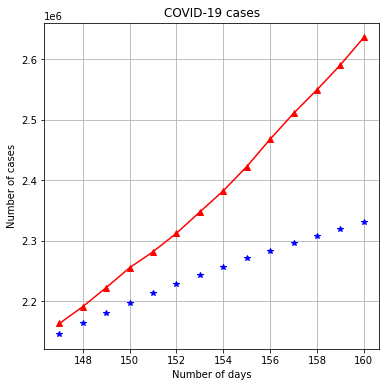

Epoch:                   10 Loss: 0.00010600
Loss on test predictions: 0.014934957958757877


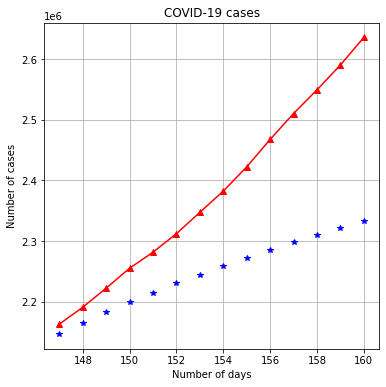

Epoch:                   11 Loss: 0.00009497
Loss on test predictions: 0.014740542508661747


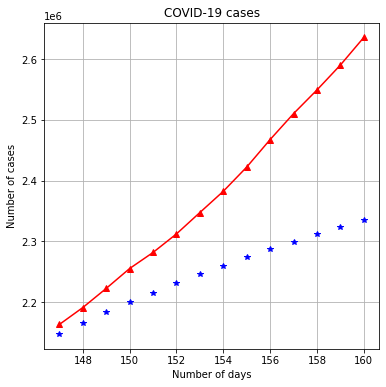

Epoch:                   12 Loss: 0.00008858
Loss on test predictions: 0.014641149900853634


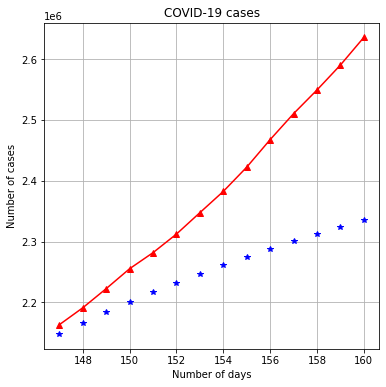

Epoch:                   13 Loss: 0.00008492
Loss on test predictions: 0.014594601467251778


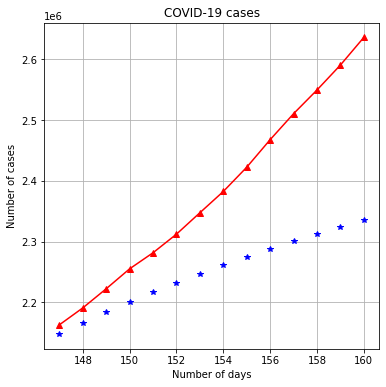

Epoch:                   14 Loss: 0.00008259
Loss on test predictions: 0.014567987062036991


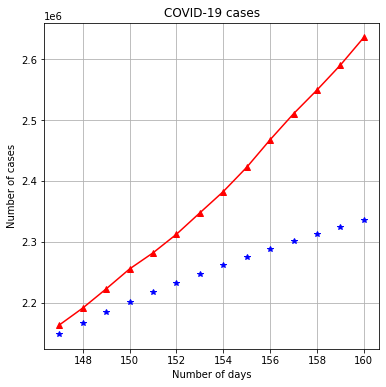

Epoch:                   15 Loss: 0.00008062
Loss on test predictions: 0.01453930139541626


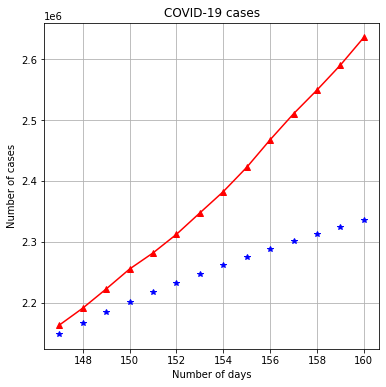

Epoch:                   16 Loss: 0.00007842
Loss on test predictions: 0.014496644027531147


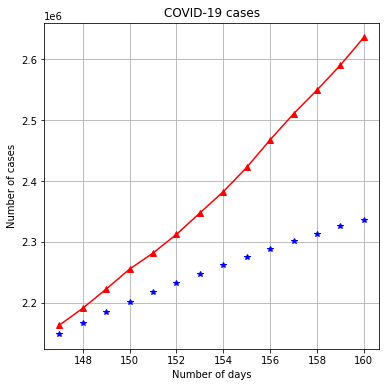

Epoch:                   17 Loss: 0.00007573
Loss on test predictions: 0.014436536468565464


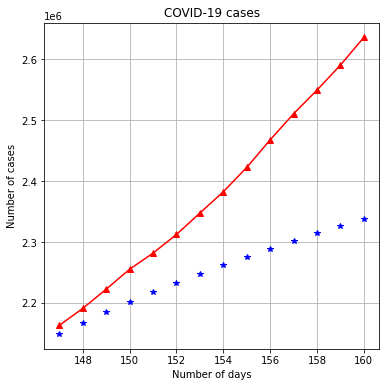

Epoch:                   18 Loss: 0.00007255
Loss on test predictions: 0.014361536130309105


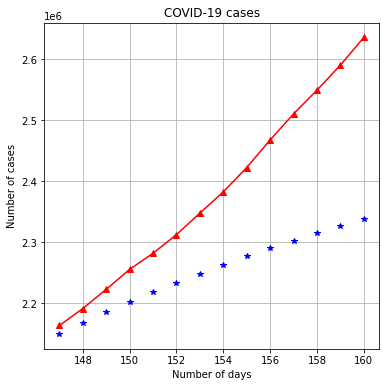

Epoch:                   19 Loss: 0.00006903
Loss on test predictions: 0.014277486130595207


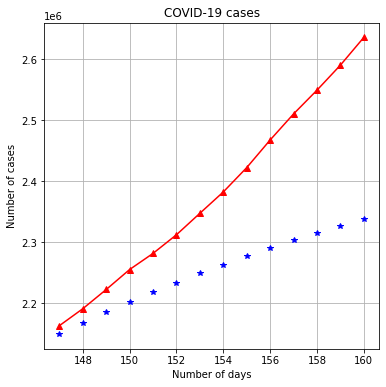

Epoch:                   20 Loss: 0.00006537
Loss on test predictions: 0.01419153530150652


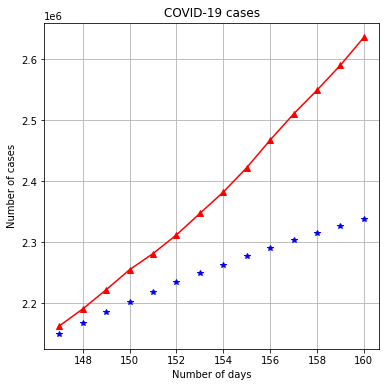


Duration: 24 seconds


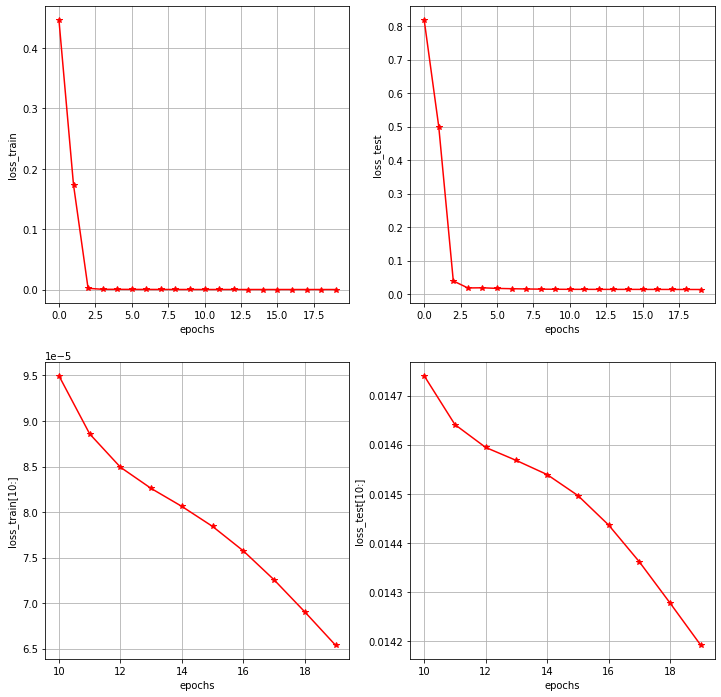

In [10]:
start_time = time.time()
epochs_test = eps
future_test = len(test_set)
# Define a window size (defined with model parameters)
# Convert train_norm from an array to a tensor
train_set = torch.FloatTensor(train_set).view(-1).cuda()
y = torch.FloatTensor(y).view(-1)
# Apply the input_data function to train_norm
train_data = input_data(train_set,window_size)
loss_train=[]
loss_test=[]
for epoch in range(epochs_test):
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                        torch.zeros(model.num_layers,1,model.hidden_size).cuda())
        y_pred = model(seq)
        # y_pred = y_pred.cpu().var.detach().numpy()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1:20} Loss: {loss.item():10.8f}')
    loss_train.append(loss.item())    
    # Add the last window of training values to the list of predictions
    preds = train_set[-window_size:].tolist()
    for i in range(future_test):
        seq = torch.FloatTensor(preds[-window_size:]).cuda()
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                            torch.zeros(model.num_layers,1,model.hidden_size).cuda())
            preds.append(model(seq).item())    
    true_predictions = scaler.inverse_transform(np.array(preds[-future_test:]).reshape(-1, 1))
    loss1 = criterion(torch.tensor(preds[-future_test:]),(y[-future_test:]))
    print(f'Loss on test predictions: {loss1}')
    loss_test.append(loss1.item())
    # print training result
    # Plot the end of the graph
    fig1 = plt.figure(figsize=(6,6))
    plt.title('COVID-19 cases')
    plt.ylabel('Number of cases')
    plt.xlabel('Number of days')
    plt.grid(True)
    # Select the end of the graph with slice notation:
    #plt.plot(df.cases[:],'-r')
    plt.plot(x[-future_test:],y_org[-future_test:], '-^r')
    plt.plot(test_set_x,true_predictions, '*b')
    plt.show()
#     fig = plt.figure(figsize=(6,6))
#     plt.plot(test_set_x,test_set, '-^r')
#     plt.plot(test_set_x,np.asarray(preds[-future:]), '*b')
#     plt.title('COVID-19 cases_norm')
#     plt.ylabel('Number of cases_norm')
#     plt.grid(True)
#     plt.show()
fig_name1='RNN_TTpred_eps'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'.png'
fig1.savefig(fig_name1, bbox_inches='tight')
warnings.filterwarnings(action='ignore')    
fig2 = plt.figure(figsize=(12,12))
plt.subplot(224)
plt.subplot(2,2,1)
plt.plot(np.arange(epochs_test),(loss_train),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_train')
plt.subplot(2,2,2)
plt.plot(np.arange(epochs_test),(loss_test),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_test')
plt.subplot(2,2,3)
plt.plot(np.arange(10, epochs_test),(loss_train[10:]),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_train[10:]')
plt.subplot(2,2,4)
plt.plot(np.arange(10, epochs_test),(loss_test[10:]),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_test[10:]')
fig_name2='RNN_TTloss_eps'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'.png'
fig2.savefig(fig_name2, bbox_inches='tight')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

# Simultaneous training on the total data and forecating the trends 

Epoch:  1 Loss: 0.00019758


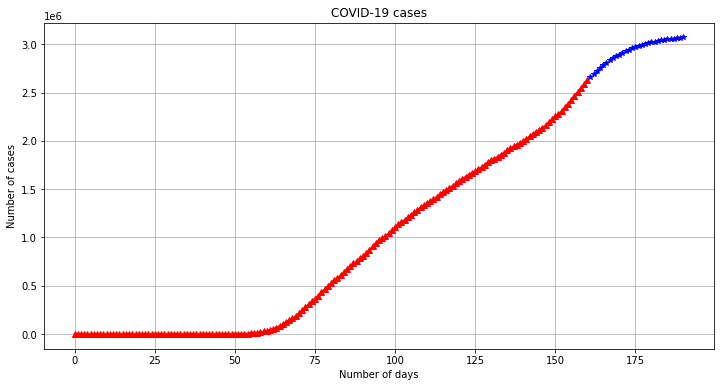

Epoch:  2 Loss: 0.00002877


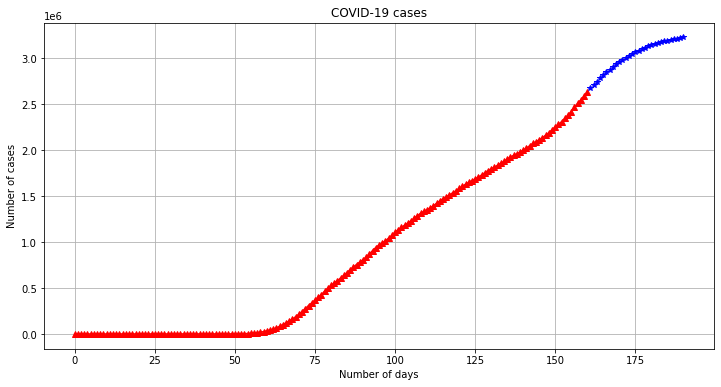

Epoch:  3 Loss: 0.00007471


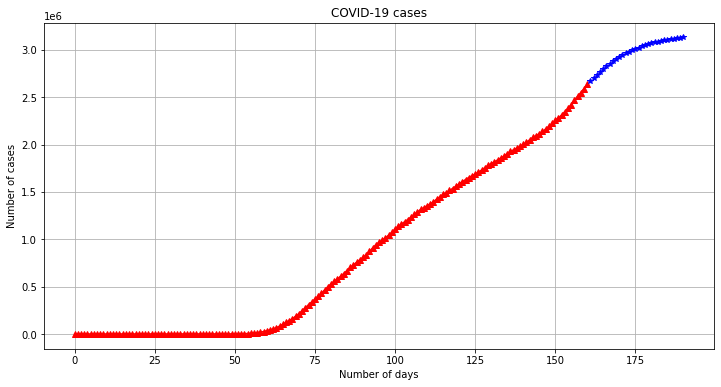

Epoch:  4 Loss: 0.00001971


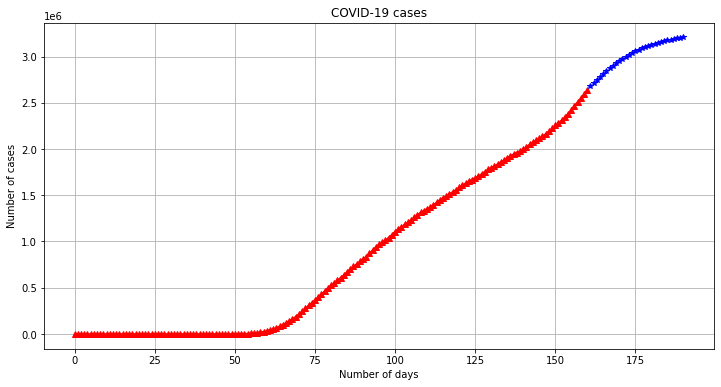

Epoch:  5 Loss: 0.00003137


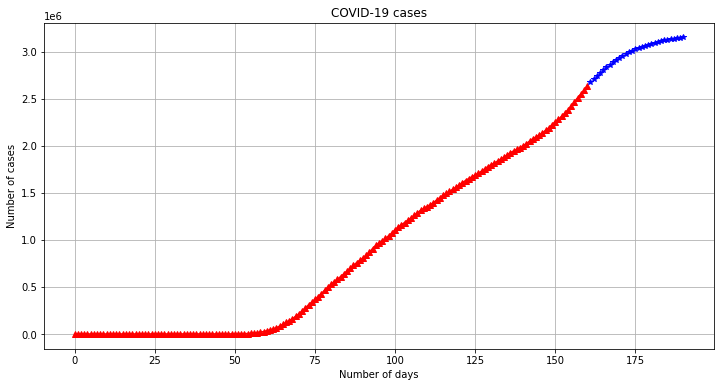

Epoch:  6 Loss: 0.00001431


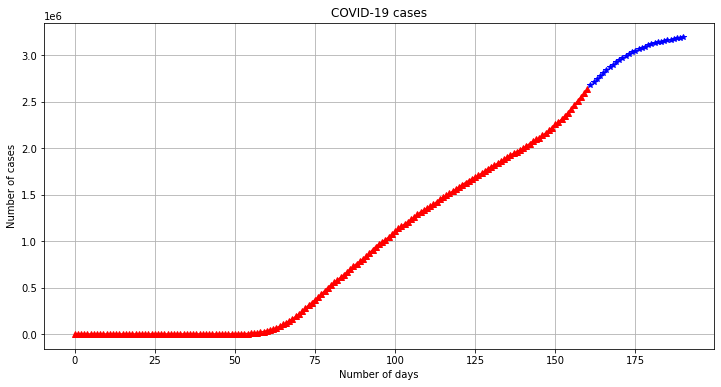

Epoch:  7 Loss: 0.00001712


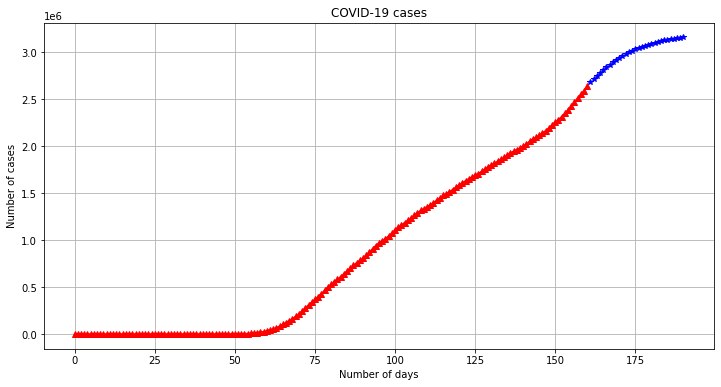

Epoch:  8 Loss: 0.00001332


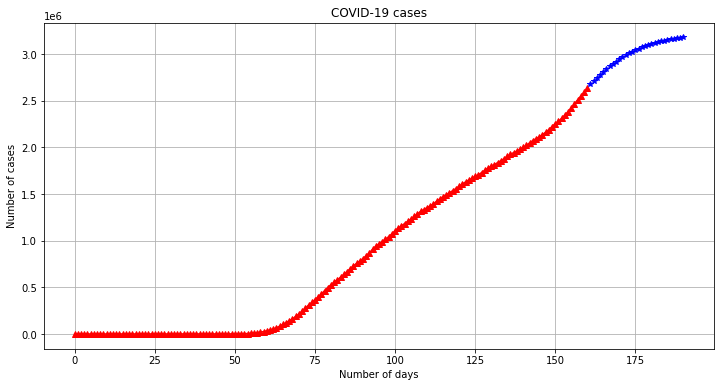

Epoch:  9 Loss: 0.00001443


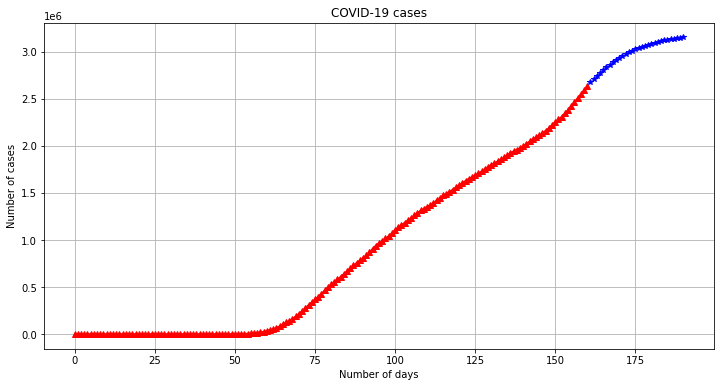

Epoch: 10 Loss: 0.00001161


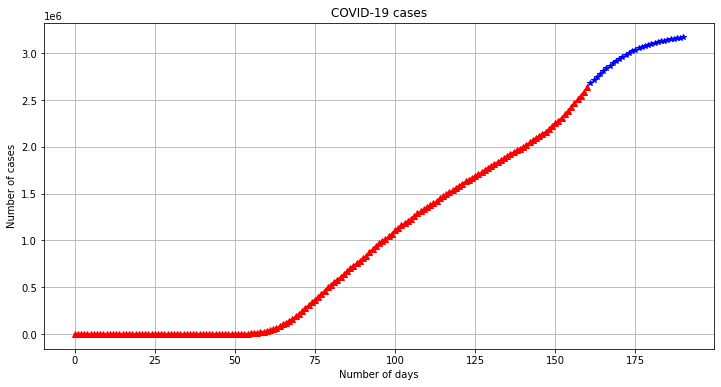

Epoch: 11 Loss: 0.00001164


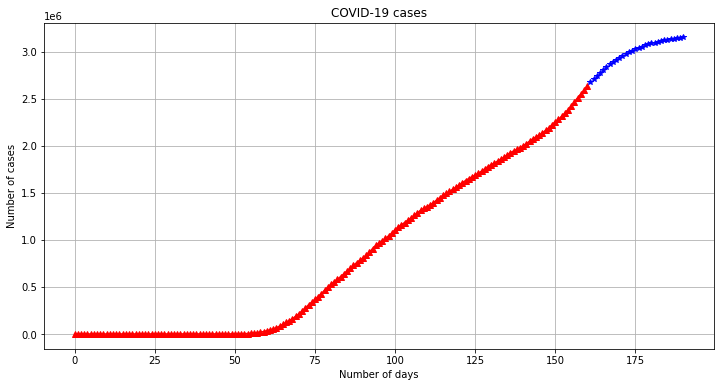

Epoch: 12 Loss: 0.00000583


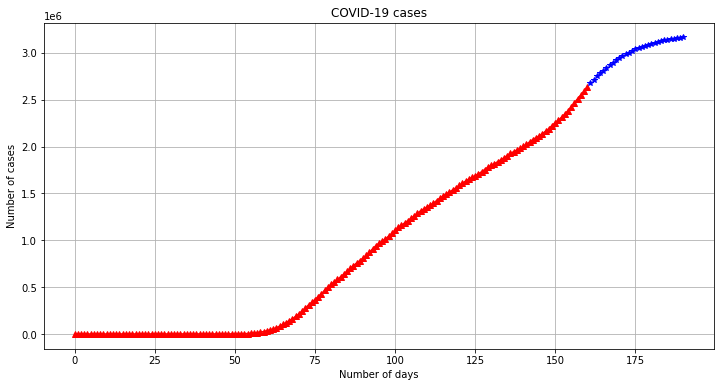

Epoch: 13 Loss: 0.00000423


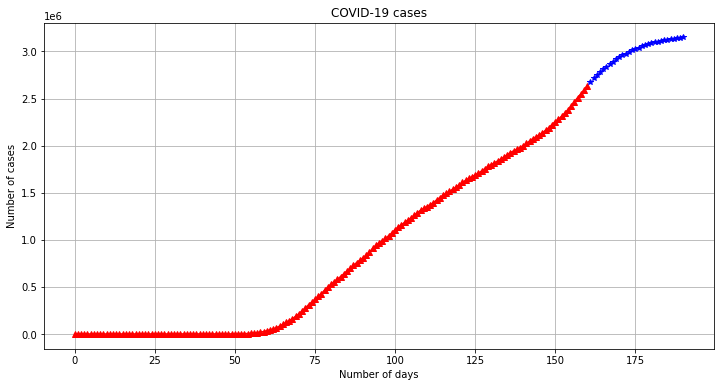

Epoch: 14 Loss: 0.00000067


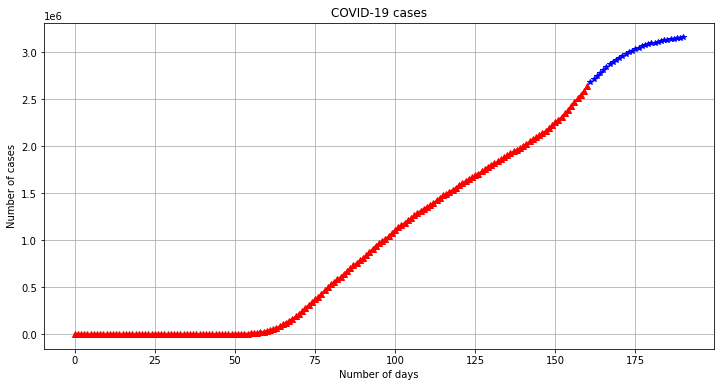

Epoch: 15 Loss: 0.00000021


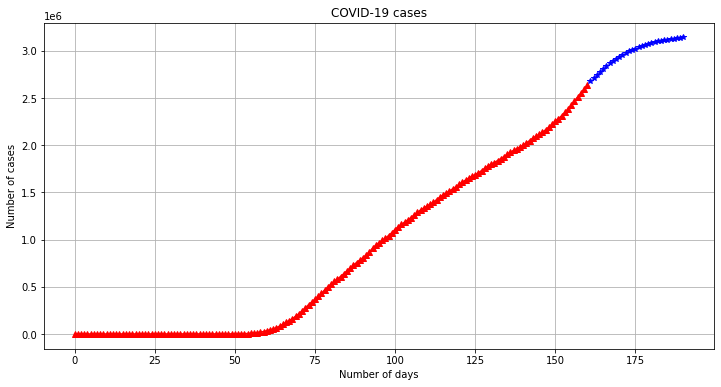

Epoch: 16 Loss: 0.00000003


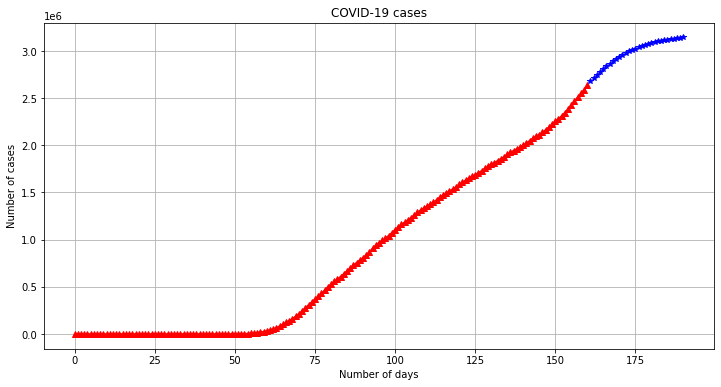


Duration: 21 seconds


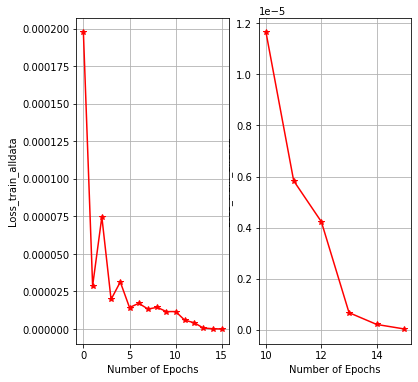

In [11]:
epochs_future = 16 #eps
real_future = 30
# Define a window size (defined with model parameters)
start_time = time.time()
loss_train_alld=[]
y = torch.FloatTensor(y).view(-1).cuda()
all_data = input_data(y,window_size)
for epoch in range(epochs_future):
    # extract the sequence & label from the training data
    for seq, y_train in all_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                        torch.zeros(model.num_layers,1,model.hidden_size).cuda())
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    loss_train_alld.append(loss.item())    
    # Add the last window of training values to the list of predictions
    preds = y[-window_size:].tolist()
    for i in range(real_future):
        seq = torch.FloatTensor(preds[-window_size:]).cuda()
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                            torch.zeros(model.num_layers,1,model.hidden_size).cuda())
            preds.append(model(seq).item())    
    future_predictions = scaler.inverse_transform(np.array(preds[-real_future:]).reshape(-1, 1))
    # print training result
    # Plot the end of the graph
    fig3 = plt.figure(figsize=(12,6))
    plt.title('COVID-19 cases')
    plt.ylabel('Number of cases')
    plt.xlabel('Number of days')
    plt.grid(True)
    # Select the end of the graph with slice notation:
    plt.plot(y_org, '-^r')
    plt.plot(np.arange(len(y_org), len(y_org)+real_future),future_predictions, '*b')
    plt.show()
fig_name3='RNN_FP_eps'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'.png'
fig3.savefig(fig_name3, bbox_inches='tight')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')
fig4 = plt.figure(figsize=(6,6))
plt.subplot(122)
plt.subplot(121)
plt.plot(np.arange(epochs_future),(loss_train_alld),'*-r')
plt.grid (True)
plt.ylabel('Loss_train_alldata')
plt.xlabel('Number of Epochs')
plt.subplot(122)
plt.plot(np.arange(10,epochs_future),(loss_train_alld[10:]),'*-r')
plt.grid (True)
plt.ylabel('Loss_train_alldata')
plt.xlabel('Number of Epochs')
warnings.filterwarnings(action='once')
fig_name4='RNN_FPloss_eps'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'.png'
fig4.savefig(fig_name4, bbox_inches='tight')